# 4TIN811U Machine Learning & Deep Learning
# TP 9 - Intro aux réseaux de neurones

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## 1. Mon premier réseau de neurones

Le fichier `dataset_tp9_apples.npy` contient un dataset sur la qualité des pommes : c'est un sur-ensemble du dataset du TP 2. Il comporte 7 features (Size, Weight, Sweetness, Crunchiness, Juiciness, Ripeness, Acidity), et les pommes sont classifiées entre les pommes bonnes ($y^{(i)}=1$) et les pommes mauvaises ($y^{(i)}=0$).

Importez les données et séparez les entre 80% de données d'entraînement (train), 10% de données de validation (val) et 10% de données de test (test). On pourra par exemple utiliser la fonction `train_test_split` du module `sklearn.model_selection`.

Par ailleurs, il faut fournir à pytorch des *tenseurs* : c'est essentiellement, la même chose que les array de numpy. Au lieu d'utiliser la syntaxe `X = np.array(data)` on utilisera `X = torch.tensor(data, dtype=torch.float32)`.

In [2]:
import random
# Définir X_train, y_train, X_val, y_val, X_test, y_test.
data = np.load("dataset_tp9_apples.npy")
np.random.shuffle(data)
X_train = data[:int(len(data)*0.8), :-1]
y_train = data[:int(len(data)*0.8), -1:]
X_val = data[int(len(data)*0.8):int(len(data)*0.9), :-1]
y_val = data[int(len(data)*0.8):int(len(data)*0.9), -1:]
X_test = data[int(len(data)*0.9):, :-1]
y_test = data[int(len(data)*0.9):, -1:]

# Afficher les dimensions des ensembles de données pour vérification
print("Dimensions de l'ensemble d'entraînement (X_train, y_train):", X_train.shape, y_train.shape)
print("Dimensions de l'ensemble de validation (X_val, y_val):", X_val.shape, y_val.shape)
print("Dimensions de l'ensemble de test (X_test, y_test):", X_test.shape, y_test.shape)

Dimensions de l'ensemble d'entraînement (X_train, y_train): (3200, 7) (3200, 1)
Dimensions de l'ensemble de validation (X_val, y_val): (400, 7) (400, 1)
Dimensions de l'ensemble de test (X_test, y_test): (400, 7) (400, 1)


On va se servir du module `pytorch` pour définir notre premier réseau de neurones.
Il y a plusieurs (hyper)paramètres importants:
- l'architecture du réseau (nombre de couches, nombres de neurones par couches, etc)
- la fonction d'erreur (loss function)
- l'optimizer : à partir de valeurs des gradients, comment mettre à jour les poids.

On s'intéresse à un problème de classification binaire, on va donc utiliser comme fonction d'erreur l'entropiée croisée (vue dans le cours sur la régression logistique):
$$J(x,y) = - (y \log(\hat y) + (1-y) \log(1- \hat y)).$$

In [3]:
loss_function = nn.BCELoss() # BCE: binary cross entropy

On va commencer par définir un réseau de neurones très simple, avec un neurone muni de la fonction d'activation sigmoïde
$$\sigma(z) = \frac{1}{1+e^{-z}}.$$ 

In [4]:
n = X_train.shape[1]
model = nn.Sequential(
    nn.Linear(n, 1),
    nn.Sigmoid()
)
print(model)

Sequential(
  (0): Linear(in_features=7, out_features=1, bias=True)
  (1): Sigmoid()
)


Ce modèle correspond à un modèle déjà vu en cours. Lequel ?

**Réponse** 
il correspond a une regression logistique.

Pour l'optimizer, on va utiliser pour le moment la descente de gradient stochastique : on met à jour tous les paramètres dans la direction opposée à leur gradient, de sorte à diminuer l'erreur.
**C'est ici qu'on peut changer le learning rate (lr).**

In [5]:
optimizer = optim.SGD(model.parameters(), lr=1) # SGD: stochastic gradient descent

On va ensuite entraîner notre réseau sur les données de test. On fera des mini_batch de taille 100 (c'est-à-dire que quand on calcule le gradient, on le fait uniquement sur 100 données et non pas sur l'ensemble des données d'entraînement).
Affichez régulièrement la loss.

In [6]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(X_train.shape )
print(y_train.shape )

torch.Size([3200, 7])
torch.Size([3200, 1])


In [7]:
nb_epoch = 50 # Nombre de fois qu'on itère sur chaque donnée
batch_size = 100
def trainModel(model, loss_function, optimizer, X_train, y_train,nb_epoch=50,batch_size = 100  ):
    for k in range(nb_epoch):
        running_loss = 0.0
        accuracy = 0.0
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_pred = model(X_batch)
            y_batch = y_train[i:i+batch_size]
            # On calcule l'erreur
            loss = loss_function(y_pred, y_batch) 
            # On réinitialise les gradient dans l'optimizer
            optimizer.zero_grad()
            # Algorithme de backpropagation pour calculer les gradients
            loss.backward()
            # On met à jour les paramètres avec l'optimizer.
            optimizer.step()

        #TODO : AFFICHEZ LA LOSS DE TEMPS EN TEMPS

        accuracy = ((y_pred.round() == y_batch).float().mean()).item()
        average_loss = loss.item()
        """print(f'Epoch {k} - '
          f'Accuracy: {accuracy:.4f} - '
          f'Average Loss: {average_loss:.4f}  ')"""
    return accuracy, average_loss

trainModel(model, loss_function, optimizer, X_train, y_train)

(0.7300000190734863, 0.5128970146179199)

In [8]:
from torch.optim.lr_scheduler import LambdaLR

optimizer = optim.SGD(model.parameters(), lr=1e-10, momentum=0.9)
lambda1 = lambda epoch: 10**(epoch/10)
scheduler = LambdaLR(optimizer, lr_lambda=[lambda1])

tabLearningRate=[]
tabLoss=[]

epoch=0
while(optimizer.param_groups[0]["lr"]<1 and optimizer.param_groups[0]["lr"]!= None):
    accuracy, average_loss = trainModel(model, loss_function, optimizer, X_train, y_train)
    scheduler.step()

    tabLearningRate+= [optimizer.param_groups[0]["lr"]]
    tabLoss+=[average_loss]
    

    print(f'Epoch {epoch} - '
          f'Accuracy: {accuracy:.4f} - '
          f'Average Loss: {average_loss:.4f} - '
          f'Learning Rate: {optimizer.param_groups[0]["lr"]:}')
    epoch+=1

Epoch 0 - Accuracy: 0.7900 - Average Loss: 0.4820 - Learning Rate: 1.2589254117941675e-10
Epoch 1 - Accuracy: 0.7900 - Average Loss: 0.4820 - Learning Rate: 1.5848931924611137e-10
Epoch 2 - Accuracy: 0.7900 - Average Loss: 0.4820 - Learning Rate: 1.9952623149688795e-10
Epoch 3 - Accuracy: 0.7900 - Average Loss: 0.4820 - Learning Rate: 2.5118864315095804e-10
Epoch 4 - Accuracy: 0.7900 - Average Loss: 0.4820 - Learning Rate: 3.1622776601683795e-10
Epoch 5 - Accuracy: 0.7900 - Average Loss: 0.4820 - Learning Rate: 3.9810717055349725e-10
Epoch 6 - Accuracy: 0.7900 - Average Loss: 0.4820 - Learning Rate: 5.011872336272723e-10
Epoch 7 - Accuracy: 0.7900 - Average Loss: 0.4820 - Learning Rate: 6.309573444801933e-10
Epoch 8 - Accuracy: 0.7900 - Average Loss: 0.4820 - Learning Rate: 7.943282347242817e-10
Epoch 9 - Accuracy: 0.7900 - Average Loss: 0.4820 - Learning Rate: 1e-09
Epoch 10 - Accuracy: 0.7900 - Average Loss: 0.4820 - Learning Rate: 1.2589254117941675e-09
Epoch 11 - Accuracy: 0.7900 -

Epoch 93 - Accuracy: 0.7800 - Average Loss: 0.5103 - Learning Rate: 0.25118864315095824
Epoch 94 - Accuracy: 0.7900 - Average Loss: 0.5057 - Learning Rate: 0.31622776601683794
Epoch 95 - Accuracy: 0.7800 - Average Loss: 0.4989 - Learning Rate: 0.3981071705534969
Epoch 96 - Accuracy: 0.7600 - Average Loss: 0.5154 - Learning Rate: 0.5011872336272715
Epoch 97 - Accuracy: 0.7900 - Average Loss: 0.5319 - Learning Rate: 0.6309573444801944
Epoch 98 - Accuracy: 0.7800 - Average Loss: 0.5495 - Learning Rate: 0.7943282347242822
Epoch 99 - Accuracy: 0.7900 - Average Loss: 0.5831 - Learning Rate: 1.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


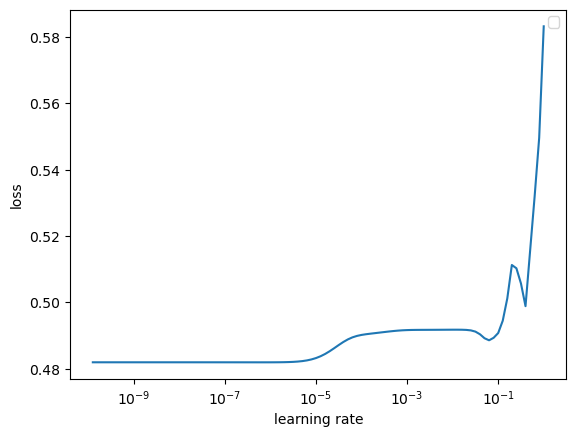

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(tabLearningRate, tabLoss)
plt.xlabel('learning rate')
plt.xscale('log')
plt.ylabel('loss')
plt.legend()

plt.show()

In [10]:
min_y = min(tabLoss)
min_index = tabLoss.index(min_y)

LearningRate = tabLearningRate[min_index]
print('best LearningRate:',LearningRate)

best LearningRate: 6.309573444801931e-07


In [11]:
optimizer_best = optim.SGD(model.parameters(), lr=LearningRate)
trainModel(model, loss_function, optimizer_best, X_train, y_train)

(0.6600000262260437, 0.6250624656677246)

Calculer les prédictions `y_pred` sur les données de test. Calculer ensuite l'accuracy, c'est-à-dire la proportions d'exemples de tests sur lesquels la prédiction est conforme à l'exemple, càd que soit :
- $\hat y > \frac{1}{2}$ et $y = 1$, ou
- $\hat y \leq \frac{1}{2}$ et $y=0$.

(Vous devriez trouver une accuracy de l'ordre de 70%.)

In [12]:
y_pred = model(X_test)
accuracy = (y_pred.round() == y_test).float().mean()
print(accuracy)

tensor(0.6725)


## 2. Mon premier VRAI réseau de neurones

Le code
```
model = nn.Sequential(
    nn.Linear(n, 1),
    nn.Sigmoid()
)
```
créé un réseau avec un couche composée d'un neurone, prenant en entrée $n$ features, avec comme fonction d'activation la sigmoïde.
Plus généralement, `nn.Linear(IN, OUT)` créé une couche prenant en entrée `IN` features et en sortant `OUT`.
On utilisera désormais comme optimizer `Adam`, qui a l'avantage par rapport à `SGD` d'optimiser la valeur du learning rate.

In [13]:
def two_layers(nb_neurons, nb_epoch=100):
    """Retourne un réseau de neurones avec une couche d'entrée à $nb_neurons$ neurones avec
    fonction d'activation ReLU, et une couche de sortie avec un neurone avec fonction 
    d'activation sigmoïde. Le réseau de neurone aura appris sur les données d'entraînement.
    Nb_epoch: Nombre de fois qu'on itère sur chaque donnée."""
    model = nn.Sequential(
            nn.Linear(n, nb_neurons),
            nn.ReLU(),
            nn.Linear(nb_neurons, 1),
            nn.Sigmoid()
    )
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_function = nn.BCELoss() 
    trainModel(model, loss_function, optimizer, X_train, y_train)
    return model

In [14]:
def accuracy(model, X_val, y_val):
    '''Retourne l'accuracy d'un réseau sur les données $(X_val, y_val)$.'''
    y_pred = model(X_val)
    return (y_pred.round() == y_val).float().mean()

Afficher un graphe montrant l'évolution de l'acuracy calculées sur les données de validation `(X_val, y_val)` selon le nombre de neurones que l'on met dans la couche d'entrée. On pourra tester pour 1, 2, 3, …, 9 neurones et 10, 20, 30, …, 90 neurones.

*Attention:* selon le choix des paramètres, le code peut prendre environ une minute à s'exécuter. Il faut s'assurer d'abord que le code fonctionne par exemple pour 10 neurones (et regardez le temps de calcul) avant de lancer des calculs plus longs.

In [15]:
accurancys=[]
for nb_neurons in range (100):
    model = two_layers(nb_neurons, nb_epoch=100)
    accurancy = accuracy(model, X_val, y_val)
    print(f'nb_neurons {nb_neurons} - '
        f'Accuracy: {accurancy:.4f} - ')
    accurancys+=[accurancy]

/Users/gabrielmariebrisson/anaconda3/lib/python3.11/site-packages/torch/nn/init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


nb_neurons 0 - Accuracy: 0.4825 - 
nb_neurons 1 - Accuracy: 0.7650 - 
nb_neurons 2 - Accuracy: 0.8000 - 
nb_neurons 3 - Accuracy: 0.8375 - 
nb_neurons 4 - Accuracy: 0.8500 - 
nb_neurons 5 - Accuracy: 0.8625 - 
nb_neurons 6 - Accuracy: 0.8650 - 
nb_neurons 7 - Accuracy: 0.8675 - 
nb_neurons 8 - Accuracy: 0.9000 - 
nb_neurons 9 - Accuracy: 0.8900 - 
nb_neurons 10 - Accuracy: 0.8700 - 
nb_neurons 11 - Accuracy: 0.9275 - 
nb_neurons 12 - Accuracy: 0.8950 - 
nb_neurons 13 - Accuracy: 0.9000 - 
nb_neurons 14 - Accuracy: 0.8925 - 
nb_neurons 15 - Accuracy: 0.9025 - 
nb_neurons 16 - Accuracy: 0.9125 - 
nb_neurons 17 - Accuracy: 0.9075 - 
nb_neurons 18 - Accuracy: 0.9175 - 
nb_neurons 19 - Accuracy: 0.8925 - 
nb_neurons 20 - Accuracy: 0.9300 - 
nb_neurons 21 - Accuracy: 0.9100 - 
nb_neurons 22 - Accuracy: 0.9075 - 
nb_neurons 23 - Accuracy: 0.9225 - 
nb_neurons 24 - Accuracy: 0.9150 - 
nb_neurons 25 - Accuracy: 0.9175 - 
nb_neurons 26 - Accuracy: 0.9300 - 
nb_neurons 27 - Accuracy: 0.9300 - 
nb

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


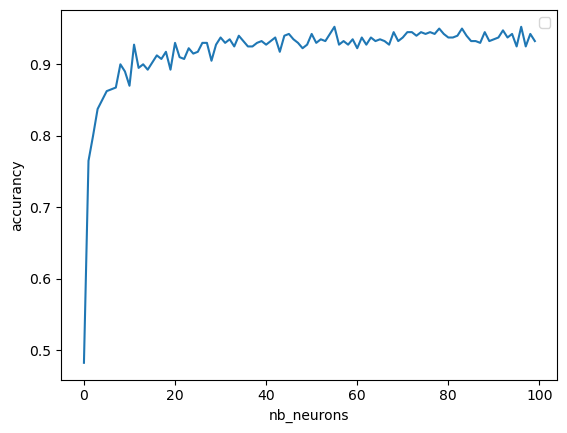

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot( accurancys)
plt.xlabel('nb_neurons')
plt.ylabel('accurancy')
plt.legend()

plt.show()

In [17]:
max_y = max(accurancys)
max_index = accurancys.index(max_y)

print('best nb_neurons:',max_index)
print('best accurancy:', max_y)

best nb_neurons: 55
best accurancy: tensor(0.9525)


Quel est le *meilleur* modèle ? Expliquez.

en terme d'accurancy, le meilleur modele est 92, apres en terme nb de neurones accurancy qui represente le mieux le nombre de calcule, c'est nb_neurons 43 qui atteint 0.9375 accurancy, soit une difference de  0.005 d'accurancy 

Pour ce modèle, augmentez le nombre d'epoch (nombre de fois où l'on itère sur chaque donnée), et affichez un graph donnant l'évolution au cours du temps de l'accuracy sur les données **d'entraînement** et de l'accuracy sur les données de **validation** selon l'epoch.

In [18]:
nb_epoch = 1000 # Nombre de fois qu'on itère sur chaque donnée
batch_size = 100
def GraphModel(model, loss_function, optimizer, X_train, y_train,X_val, y_val,nb_epoch = 1000, batch_size = 100):
    tab_accuracy_train = []
    tab_loss_train = []
    
    tab_accuracy_val = []
    tab_loss_val = []
    
    best_loss=10
    
    for k in range(nb_epoch):
        running_loss = 0.0
        accuracy = 0.0
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_pred = model(X_batch)
            y_batch = y_train[i:i+batch_size]
            # On calcule l'erreur
            loss = loss_function(y_pred, y_batch) 
            # On réinitialise les gradient dans l'optimizer
            optimizer.zero_grad()
            # Algorithme de backpropagation pour calculer les gradients
            loss.backward()
            # On met à jour les paramètres avec l'optimizer.
            optimizer.step()
        
        tab_accuracy_train += [((y_pred.round() ==  y_batch).float().mean()).item()]
        tab_loss_train += [loss.item()]
        
        with torch.no_grad():
            y_pred_val = model(X_val)
            val_accuracy = (y_pred_val.round() == y_val).float().mean().item()
            tab_accuracy_val.append(val_accuracy)
            
            val_loss = loss_function(y_pred_val, y_val).item()
            tab_loss_val.append(val_loss)
        
        if (best_loss> val_loss):
            best_loss=val_loss
            print(best_loss, k)
            torch.save(model.state_dict(), 'bestModel.pth')
        
        if k % 100 == 0:  # Print progress every 100 epochs
            print(f'Epoch {k}, Training Loss: {average_loss}, Training Accuracy: {accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')
    
    return tab_accuracy_train, tab_loss_train, tab_accuracy_val, tab_loss_val



model = nn.Sequential(
        nn.Linear(n, 43),
        nn.ReLU(),
        nn.Linear(43, 1),
        nn.Sigmoid()
)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.BCELoss() 
tab_accuracy_train, tab_loss_train, tab_accuracy_val , tab_loss_val = GraphModel(model, loss_function, optimizer, X_train, y_train,X_val, y_val)

0.37545543909072876 0
Epoch 0, Training Loss: 0.5831242203712463, Training Accuracy: 0.0, Validation Loss: 0.37545543909072876, Validation Accuracy: 0.8299999833106995
0.31620392203330994 1
0.29832085967063904 2
0.28921371698379517 3
0.28168490529060364 4
0.2751625180244446 5
0.26898032426834106 6
0.2632554769515991 7
0.2577909231185913 8
0.25156646966934204 9
0.24603062868118286 10
0.23815134167671204 11
0.23100478947162628 12
0.22287516295909882 13
0.21605569124221802 14
0.21126209199428558 15
0.20651523768901825 16
0.20223094522953033 17
0.19909057021141052 18
0.19581136107444763 19
0.193267360329628 20
0.1908751130104065 21
0.18948188424110413 22
0.18749675154685974 23
0.18623226881027222 24
0.1848035752773285 25
0.183670774102211 26
0.18277673423290253 27
0.18053442239761353 28
0.17892903089523315 29
0.17631062865257263 30
0.17567211389541626 31
0.17419447004795074 32
0.17344167828559875 33
0.17292222380638123 34
0.1719844788312912 35
0.1706971377134323 36
0.1700820028781891 37
0.

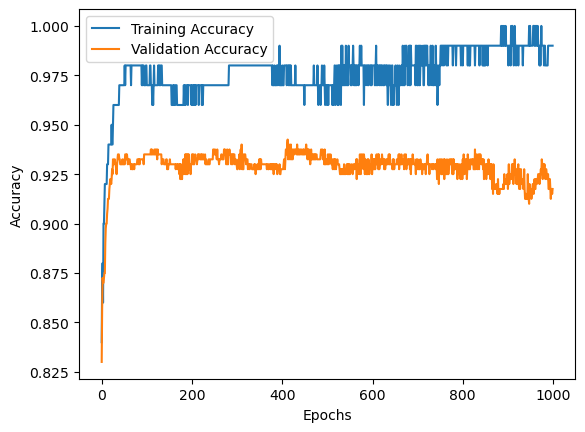

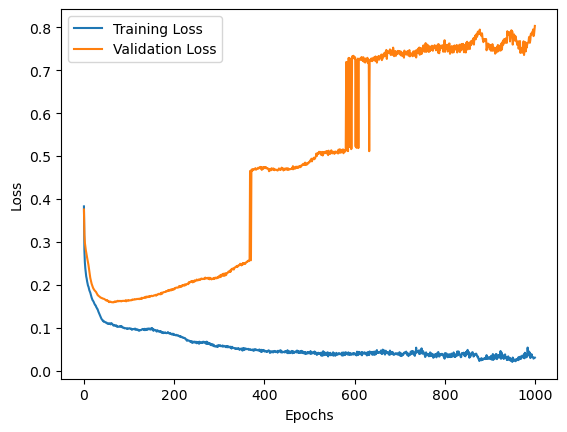

In [19]:

plt.figure()
plt.plot(tab_accuracy_train, label='Training Accuracy')
plt.plot(tab_accuracy_val, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(tab_loss_train, label='Training Loss')
plt.plot(tab_loss_val, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Combien d'epoch conseillez-vous de faire ? Quel est le nom du phénomène que l'on observe quand le nombre d'epoch devient très grand ?

**Réponse**
je conseille de faire 65 epochs car il a la meilleur loss, on observe du surapprentissage lorsque les epochs sont trop grandes 

Calculez l'accuracy sur les données de test pour le modèle choisi et le nombre d'epoch retenu.

In [20]:
model.load_state_dict(torch.load('bestModel.pth'))
model.eval()

y_pred = model(X_test)
accuracy = (y_pred.round() == y_test).float().mean()
print(accuracy)

tensor(0.9400)


Que pourrait-on améliorer dans la démarche faite dans cette section du TP ?

**Réponse**
on pourrait normaliser les données

## 3. D'autres architectures

Essayez de changer l'architecture du réseau de neurones en faisant varier le nombre de couches et les fonctions d'activation. Commentez ce que vous observez.

nb_neurons 1 - Accuracy: 0.7575 - 
nb_neurons 2 - Accuracy: 0.8150 - 
nb_neurons 3 - Accuracy: 0.8375 - 
nb_neurons 4 - Accuracy: 0.8650 - 
nb_neurons 5 - Accuracy: 0.8525 - 
nb_neurons 6 - Accuracy: 0.8750 - 
nb_neurons 7 - Accuracy: 0.8950 - 
nb_neurons 8 - Accuracy: 0.8725 - 
nb_neurons 9 - Accuracy: 0.8850 - 
nb_neurons 10 - Accuracy: 0.8875 - 
nb_neurons 11 - Accuracy: 0.8875 - 
nb_neurons 12 - Accuracy: 0.8925 - 
nb_neurons 13 - Accuracy: 0.8675 - 
nb_neurons 14 - Accuracy: 0.8850 - 
nb_neurons 15 - Accuracy: 0.8975 - 
nb_neurons 16 - Accuracy: 0.8825 - 
nb_neurons 17 - Accuracy: 0.9100 - 
nb_neurons 18 - Accuracy: 0.8975 - 
nb_neurons 19 - Accuracy: 0.9025 - 
nb_neurons 20 - Accuracy: 0.9025 - 
nb_neurons 21 - Accuracy: 0.9000 - 
nb_neurons 22 - Accuracy: 0.8900 - 
nb_neurons 23 - Accuracy: 0.8975 - 
nb_neurons 24 - Accuracy: 0.8950 - 
nb_neurons 25 - Accuracy: 0.8900 - 
nb_neurons 26 - Accuracy: 0.8950 - 
nb_neurons 27 - Accuracy: 0.9075 - 
nb_neurons 28 - Accuracy: 0.8925 - 
n

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


nb_neurons 99 - Accuracy: 0.9000 - 


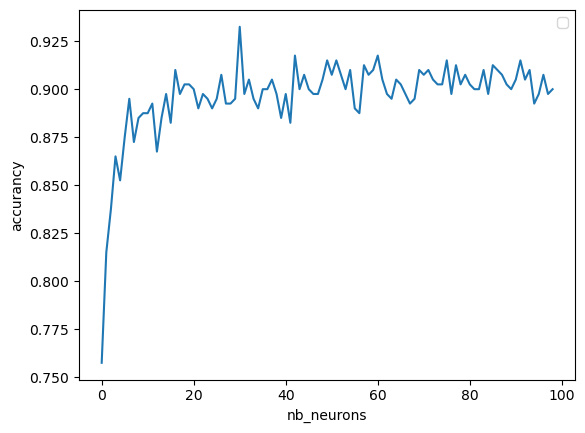

best nb_neurons: 31
best accurancy: tensor(0.9325)


In [21]:
def two_layers_batch(nb_neurons, nb_epoch=100):
    """Retourne un réseau de neurones avec une couche d'entrée à $nb_neurons$ neurones avec
    fonction d'activation ReLU, et une couche de sortie avec un neurone avec fonction 
    d'activation sigmoïde. Le réseau de neurone aura appris sur les données d'entraînement.
    Nb_epoch: Nombre de fois qu'on itère sur chaque donnée."""
    model = nn.Sequential(
        nn.BatchNorm1d(n),
        nn.Linear(n, nb_neurons),
        nn.ReLU(),
        nn.BatchNorm1d(nb_neurons),
        nn.Linear(nb_neurons, 1),
        nn.Sigmoid()
    )
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_function = nn.BCELoss() 
    trainModel(model, loss_function, optimizer, X_train, y_train)
    return model

def accuracy(model, X_val, y_val):
    '''Retourne l'accuracy d'un réseau sur les données $(X_val, y_val)$.'''
    y_pred = model(X_val)
    return (y_pred.round() == y_val).float().mean()

accurancys=[]
for nb_neurons in range (1,100):
    model = two_layers_batch(nb_neurons, nb_epoch=100)
    accurancy = accuracy(model, X_val, y_val)
    print(f'nb_neurons {nb_neurons} - '
        f'Accuracy: {accurancy:.4f} - ')
    accurancys+=[accurancy]

import matplotlib.pyplot as plt

plt.figure()
plt.plot( accurancys)
plt.xlabel('nb_neurons')
plt.ylabel('accurancy')
plt.legend()

plt.show()

max_y = max(accurancys)
max_index = accurancys.index(max_y)+1

print('best nb_neurons:',max_index)
print('best accurancy:', max_y)

In [22]:
model = nn.Sequential(
        nn.BatchNorm1d(n),
        nn.Linear(n, max_index),
        nn.ReLU(),
        nn.BatchNorm1d(max_index),
        nn.Linear(max_index, 1),
        nn.Sigmoid()
)


from torch.optim.lr_scheduler import LambdaLR

optimizer = optim.SGD(model.parameters(), lr=1e-10, momentum=0.9)
lambda1 = lambda epoch: 10**(epoch/10)
scheduler = LambdaLR(optimizer, lr_lambda=[lambda1])

tabLearningRate=[]
tabLoss=[]

epoch=0
while(optimizer.param_groups[0]["lr"]<1 and optimizer.param_groups[0]["lr"]!= None):
    accuracy, average_loss = trainModel(model, loss_function, optimizer, X_train, y_train)
    scheduler.step()

    tabLearningRate+= [optimizer.param_groups[0]["lr"]]
    tabLoss+=[average_loss]
    

    print(f'Epoch {epoch} - '
          f'Accuracy: {accuracy:.4f} - '
          f'Average Loss: {average_loss:.4f} - '
          f'Learning Rate: {optimizer.param_groups[0]["lr"]:}')
    epoch+=1
    
min_y = min(tabLoss)
min_index = tabLoss.index(min_y)

LearningRate = tabLearningRate[min_index]
print('best LearningRate:',LearningRate)


Epoch 0 - Accuracy: 0.4900 - Average Loss: 0.7533 - Learning Rate: 1.2589254117941675e-10
Epoch 1 - Accuracy: 0.4900 - Average Loss: 0.7533 - Learning Rate: 1.5848931924611137e-10
Epoch 2 - Accuracy: 0.4900 - Average Loss: 0.7533 - Learning Rate: 1.9952623149688795e-10
Epoch 3 - Accuracy: 0.4900 - Average Loss: 0.7533 - Learning Rate: 2.5118864315095804e-10
Epoch 4 - Accuracy: 0.4900 - Average Loss: 0.7533 - Learning Rate: 3.1622776601683795e-10
Epoch 5 - Accuracy: 0.4900 - Average Loss: 0.7533 - Learning Rate: 3.9810717055349725e-10
Epoch 6 - Accuracy: 0.4900 - Average Loss: 0.7533 - Learning Rate: 5.011872336272723e-10
Epoch 7 - Accuracy: 0.4900 - Average Loss: 0.7533 - Learning Rate: 6.309573444801933e-10
Epoch 8 - Accuracy: 0.4900 - Average Loss: 0.7533 - Learning Rate: 7.943282347242817e-10
Epoch 9 - Accuracy: 0.4900 - Average Loss: 0.7533 - Learning Rate: 1e-09
Epoch 10 - Accuracy: 0.4900 - Average Loss: 0.7533 - Learning Rate: 1.2589254117941675e-09
Epoch 11 - Accuracy: 0.4900 -

Epoch 93 - Accuracy: 0.9000 - Average Loss: 0.2100 - Learning Rate: 0.25118864315095824
Epoch 94 - Accuracy: 0.9200 - Average Loss: 0.2169 - Learning Rate: 0.31622776601683794
Epoch 95 - Accuracy: 0.8800 - Average Loss: 0.3181 - Learning Rate: 0.3981071705534969
Epoch 96 - Accuracy: 0.9000 - Average Loss: 0.2152 - Learning Rate: 0.5011872336272715
Epoch 97 - Accuracy: 0.9400 - Average Loss: 0.2072 - Learning Rate: 0.6309573444801944
Epoch 98 - Accuracy: 0.8400 - Average Loss: 0.3485 - Learning Rate: 0.7943282347242822
Epoch 99 - Accuracy: 0.7800 - Average Loss: 0.5381 - Learning Rate: 1.0
best LearningRate: 0.06309573444801944


In [23]:

optimizer = optim.SGD(model.parameters(), lr=LearningRate)
loss_function = nn.BCELoss() 
tab_accuracy_train, tab_loss_train, tab_accuracy_val , tab_loss_val = GraphModel(model, loss_function, optimizer, X_train, y_train,X_val, y_val, nb_epoch=10000)

model.load_state_dict(torch.load('bestModel.pth'))
model.eval()

y_pred = model(X_test)
accuracy = (y_pred.round() == y_test).float().mean()
print(accuracy)

0.259272038936615 0
Epoch 0, Training Loss: 0.5381007194519043, Training Accuracy: 0.0, Validation Loss: 0.259272038936615, Validation Accuracy: 0.8799999952316284
0.252736896276474 1
0.24895846843719482 2
0.24672894179821014 3
0.24530820548534393 4
0.24435770511627197 5
0.24373525381088257 6
0.2432960867881775 7
0.24297039210796356 8
0.24275916814804077 9
0.24265338480472565 10
0.24260100722312927 11
Epoch 100, Training Loss: 0.5381007194519043, Training Accuracy: 0.0, Validation Loss: 0.2474292814731598, Validation Accuracy: 0.887499988079071
Epoch 200, Training Loss: 0.5381007194519043, Training Accuracy: 0.0, Validation Loss: 0.24951279163360596, Validation Accuracy: 0.8849999904632568
Epoch 300, Training Loss: 0.5381007194519043, Training Accuracy: 0.0, Validation Loss: 0.25000691413879395, Validation Accuracy: 0.8824999928474426
Epoch 400, Training Loss: 0.5381007194519043, Training Accuracy: 0.0, Validation Loss: 0.24993404746055603, Validation Accuracy: 0.8849999904632568
Epoch

Epoch 5400, Training Loss: 0.5381007194519043, Training Accuracy: 0.0, Validation Loss: 0.25329315662384033, Validation Accuracy: 0.8974999785423279
Epoch 5500, Training Loss: 0.5381007194519043, Training Accuracy: 0.0, Validation Loss: 0.2499408721923828, Validation Accuracy: 0.8974999785423279
Epoch 5600, Training Loss: 0.5381007194519043, Training Accuracy: 0.0, Validation Loss: 0.24845081567764282, Validation Accuracy: 0.8999999761581421
Epoch 5700, Training Loss: 0.5381007194519043, Training Accuracy: 0.0, Validation Loss: 0.24697251617908478, Validation Accuracy: 0.9024999737739563
Epoch 5800, Training Loss: 0.5381007194519043, Training Accuracy: 0.0, Validation Loss: 0.24805858731269836, Validation Accuracy: 0.9049999713897705
Epoch 5900, Training Loss: 0.5381007194519043, Training Accuracy: 0.0, Validation Loss: 0.24832063913345337, Validation Accuracy: 0.9049999713897705
Epoch 6000, Training Loss: 0.5381007194519043, Training Accuracy: 0.0, Validation Loss: 0.24939538538455963

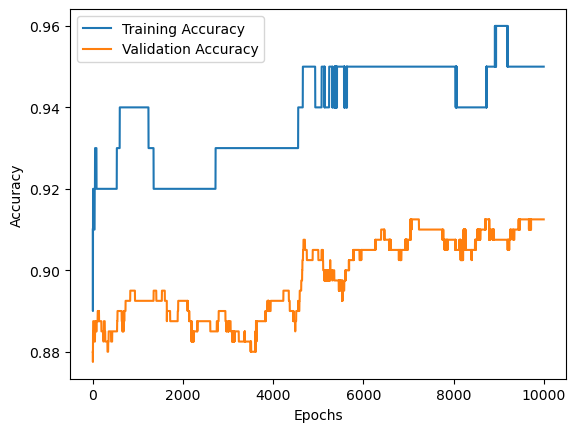

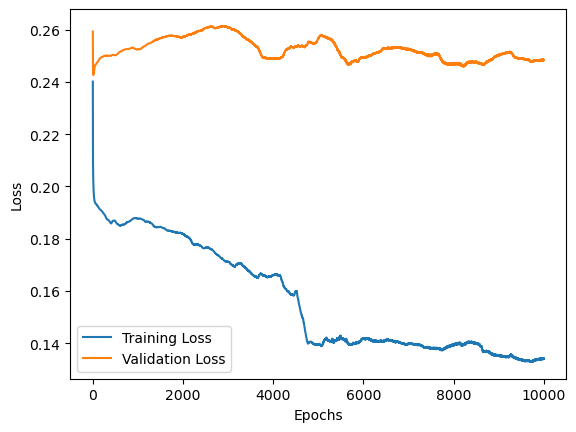

In [24]:

plt.figure()
plt.plot(tab_accuracy_train, label='Training Accuracy')
plt.plot(tab_accuracy_val, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(tab_loss_train, label='Training Loss')
plt.plot(tab_loss_val, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [25]:
model.load_state_dict(torch.load('bestModel.pth'))
model.eval()

y_pred = model(X_test)
accuracy = (y_pred.round() == y_test).float().mean()
print(accuracy)

tensor(0.8950)
